In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re

df = pd.read_csv('Pre-time-series.csv')

# identify PH patients (I27.0, I27.2, I27.9)
ph_codes = ['I27.0', 'I27.2', 'I27.9']
ph_patients = df[df['Combined ICD10 Codes'].isin(ph_codes)]

# earliest PH diagnosis date per patient
ph_dates = ph_patients.groupby('Participant ID')['Combined ICD10 Diagnosis Date'].min().reset_index()
ph_dates.rename(columns={'Combined ICD10 Diagnosis Date': 'PH Diagnosis Date'}, inplace=True)

# only PH ppt
ph_participant_ids = ph_dates['Participant ID'].unique()
df_ph_patients = df[df['Participant ID'].isin(ph_participant_ids)]
merged = df_ph_patients.merge(ph_dates, on='Participant ID', how='left') # merge to get PH diagnosis date
merged = merged[~merged['Combined ICD10 Codes'].isin(ph_codes)] #exclude ph

# difference in months 
merged['Combined ICD10 Diagnosis Date'] = pd.to_datetime(merged['Combined ICD10 Diagnosis Date'])
merged['PH Diagnosis Date'] = pd.to_datetime(merged['PH Diagnosis Date'])
merged['Months Before PH'] = (merged['PH Diagnosis Date'] - merged['Combined ICD10 Diagnosis Date']).dt.days / 30.44

# assigning time periods
def assign_time_bucket(months):
    if 0 <= months <= 6:
        return '0-6 months'
    elif 6 < months <= 12:
        return '6-12 months'
    elif 12 < months <= 18:
        return '12-18 months'
    elif 18 < months <= 24:
        return '18-24 months'
    elif 24 < months <= 30:
        return '24-30 months'
    elif 30 < months <= 36:
        return '30-36 months'
    else:
        return None

merged['Time Bucket'] = merged['Months Before PH'].apply(assign_time_bucket)

# drop anything before 36m
merged = merged.dropna(subset=['Time Bucket'])

# mapping diseases
disease_mapping = {
    "Dementia": r"^F0[0-3]",
    "Depression": r"^F3[2-3]",
    "Stroke": r"^(I60|I61|I62|I63|I64)",
    "Thyroid disease": r"^E0[0-7]",
    "Atrial fibrillation": r"^I48",
    "Ischaemic heart disease": r"^I2[0-5]",
    "Left heart failure": r"^I50|I50\\.1|I50\\.9",
    "Myocardial infarction": r"^I2[1-2]",
    "Valvular disease": r"^I3[4-7]",
    "Cardiomyopathy": r"^I42",
    "COPD": r"^J44",
    "Sleep apnoea": r"^G47\\.3",
    "Asthma": r"^(J45)",
    "Restrictive airway disease": r"^(J98\\.4|J84\\.)",
    "Pulmonary embolism": r"^I26",
    "Chronic liver disease": r"^K7[0-7]",
    "Chronic kidney disease": r"^N18",
    "Diabetes": r"^E1[0-4]",
    "Essential hypertension": r"^I10",
    "Hypercholesterolemia": r"^E78\\.0"
}

def map_disease(code):
    for disease, pattern in disease_mapping.items():
        if re.match(pattern, code):
            return disease
    return None

merged['Mapped Disease'] = merged['Combined ICD10 Codes'].apply(map_disease)
merged = merged.dropna(subset=['Mapped Disease']) #only keeping mapped 

# group and count
comorbidity_counts = merged.groupby(['Time Bucket', 'Mapped Disease']).size().reset_index(name='Count')
pivot_table = comorbidity_counts.pivot(index='Mapped Disease', columns='Time Bucket', values='Count').fillna(0) #pivot to plot
pivot_table = pivot_table[['30-36 months', '24-30 months', '18-24 months', '12-18 months', '6-12 months', '0-6 months']] #reorder columns

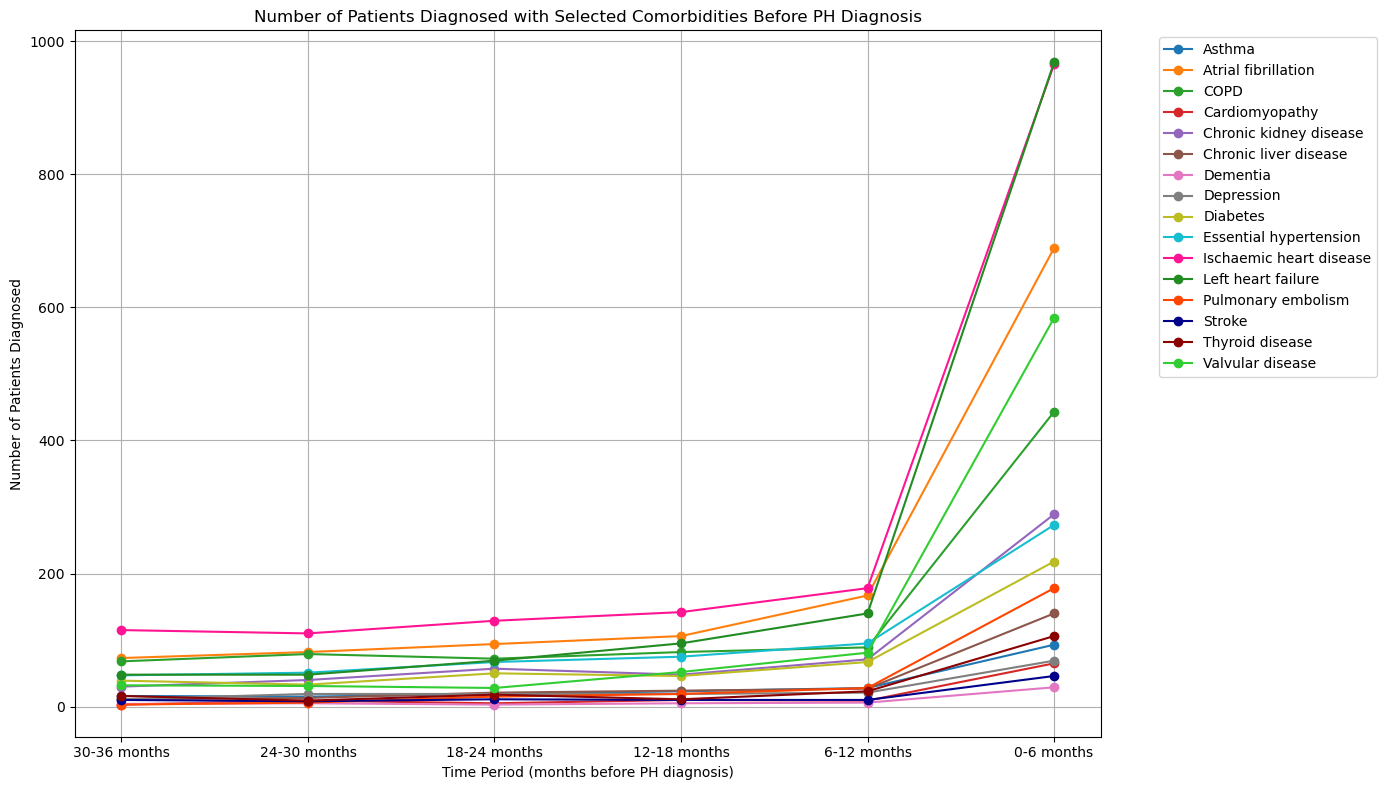

In [7]:
# number of diseases
num_diseases = len(pivot_table.index)

bold_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#ff1493', '#228b22', '#ff4500', '#00008b', '#8b0000',
    '#32cd32', '#ff6347', '#4682b4', '#6a5acd', '#b22222'
]

plt.figure(figsize=(14, 8))
for idx, disease in enumerate(pivot_table.index):
    plt.plot(
        pivot_table.columns,
        pivot_table.loc[disease],
        marker='o',
        label=disease,
        color=bold_colors[idx % len(bold_colors)]
    )

plt.xlabel('Time Period (months before PH diagnosis)')
plt.ylabel('Number of Patients Diagnosed')
plt.title('Number of Patients Diagnosed with Selected Comorbidities Before PH Diagnosis')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

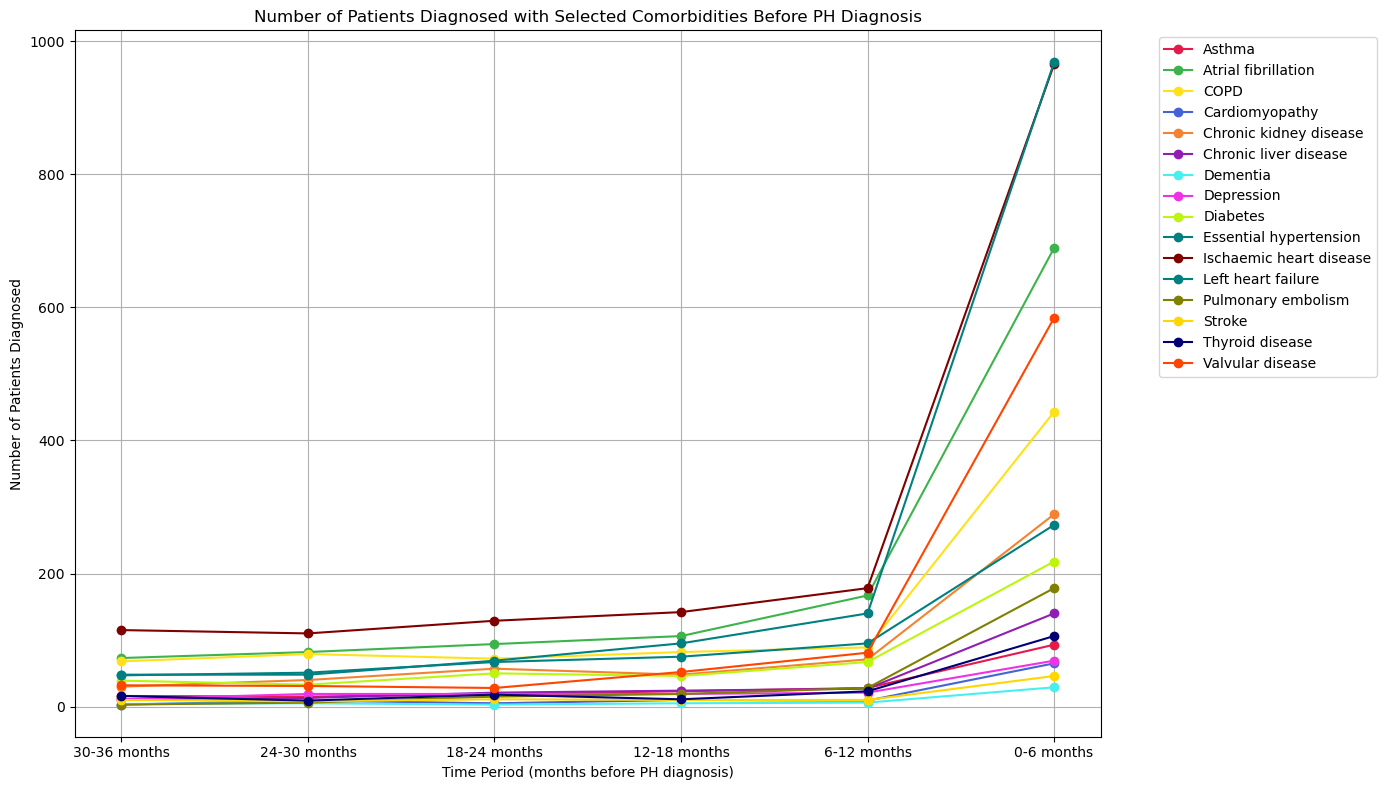

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Number of diseases
num_diseases = len(pivot_table.index)

bold_colors = [
    '#e6194b',  # strong red
    '#3cb44b',  # medium green
    '#ffe119',  # bright yellow (still legible but borderline)
    '#4363d8',  # royal blue
    '#f58231',  # orange
    '#911eb4',  # dark purple
    '#46f0f0',  # cyan
    '#f032e6',  # hot pink
    '#bcf60c',  # lime green
    '#008080',  # dark teal
    '#800000',  # maroon
    '#008080',  # teal
    '#808000',  # olive
    '#ffd700',  # gold
    '#000075',  # navy blue
    '#ff4500',  # orange-red
    '#228b22',  # forest green
    '#6a5acd',  # slate blue
    '#b22222',  # firebrick
    '#000000'   # black
]

plt.figure(figsize=(14, 8))
for idx, disease in enumerate(pivot_table.index):
    plt.plot(
        pivot_table.columns,
        pivot_table.loc[disease],
        marker='o',
        label=disease,
        color=bold_colors[idx % len(bold_colors)]
    )

plt.xlabel('Time Period (months before PH diagnosis)')
plt.ylabel('Number of Patients Diagnosed')
plt.title('Number of Patients Diagnosed with Selected Comorbidities Before PH Diagnosis')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re

df = pd.read_csv('Pre-time-series.csv')

# identify PH patients (I27.0, I27.2, I27.9)
ph_codes = ['I27.0', 'I27.2', 'I27.9']
ph_patients = df[df['Combined ICD10 Codes'].isin(ph_codes)]

# earliest PH diagnosis date per patient
ph_dates = ph_patients.groupby('Participant ID')['Combined ICD10 Diagnosis Date'].min().reset_index()
ph_dates.rename(columns={'Combined ICD10 Diagnosis Date': 'PH Diagnosis Date'}, inplace=True)

# only PH ppt
ph_participant_ids = ph_dates['Participant ID'].unique()
df_ph_patients = df[df['Participant ID'].isin(ph_participant_ids)]
merged = df_ph_patients.merge(ph_dates, on='Participant ID', how='left') # merge to get PH diagnosis date
merged = merged[~merged['Combined ICD10 Codes'].isin(ph_codes)] #exclude ph

# difference in months 
merged['Combined ICD10 Diagnosis Date'] = pd.to_datetime(merged['Combined ICD10 Diagnosis Date'])
merged['PH Diagnosis Date'] = pd.to_datetime(merged['PH Diagnosis Date'])
merged['Months Before PH'] = (merged['PH Diagnosis Date'] - merged['Combined ICD10 Diagnosis Date']).dt.days / 30.44

# assigning time periods
def assign_time_bucket(months):
    if 0 <= months <= 6:
        return '0-6 months'
    elif 6 < months <= 12:
        return '6-12 months'
    elif 12 < months <= 18:
        return '12-18 months'
    elif 18 < months <= 24:
        return '18-24 months'
    elif 24 < months <= 30:
        return '24-30 months'
    elif 30 < months <= 36:
        return '30-36 months'
    else:
        return None

merged['Time Bucket'] = merged['Months Before PH'].apply(assign_time_bucket)

# drop anything before 36m
merged = merged.dropna(subset=['Time Bucket'])

# mapping diseases
disease_mapping = {
    "Dementia": r"^F0[0-3]",
    "Depression": r"^F3[2-3]",
    "Stroke": r"^(I60|I61|I62|I63|I64)",
    "Thyroid disease": r"^E0[0-7]",
    "Atrial fibrillation": r"^I48",
    "Ischaemic heart disease": r"^I2[0-5]",
    "Left heart failure": r"^I50|I50\\.1|I50\\.9",
    "Myocardial infarction": r"^I2[1-2]",
    "Valvular disease": r"^I3[4-7]",
    "Cardiomyopathy": r"^I42",
    "COPD": r"^J44",
    "Sleep apnoea": r"^G47\\.3",
    "Asthma": r"^(J45)",
    "Restrictive airway disease": r"^(J98\\.4|J84\\.)",
    "Pulmonary embolism": r"^I26",
    "Chronic liver disease": r"^K7[0-7]",
    "Chronic kidney disease": r"^N18",
    "Diabetes": r"^E1[0-4]",
    "Essential hypertension": r"^I10",
    "Hypercholesterolemia": r"^E78\\.0"
}

def map_disease(code):
    for disease, pattern in disease_mapping.items():
        if re.match(pattern, code):
            return disease
    return None

merged['Mapped Disease'] = merged['Combined ICD10 Codes'].apply(map_disease)
merged = merged.dropna(subset=['Mapped Disease']) #only keeping mapped 

# group and count
comorbidity_counts = merged.groupby(['Time Bucket', 'Mapped Disease']).size().reset_index(name='Count')
pivot_table = comorbidity_counts.pivot(index='Mapped Disease', columns='Time Bucket', values='Count').fillna(0) #pivot to plot
pivot_table = pivot_table[['30-36 months', '24-30 months', '18-24 months', '12-18 months', '6-12 months', '0-6 months']] #reorder columns

/var/folders/_m/m9xv09r905g36k6kpxs2mq1r0000gn/T/ipykernel_29212/106054049.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sorted_data.index, rotation=90)
/var/folders/_m/m9xv09r905g36k6kpxs2mq1r0000gn/T/ipykernel_29212/106054049.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sorted_data.index, rotation=90)
/var/folders/_m/m9xv09r905g36k6kpxs2mq1r0000gn/T/ipykernel_29212/106054049.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sorted_data.index, rotation=90)
/var/folders/_m/m9xv09r905g36k6kpxs2mq1r0000gn/T/ipykernel_29212/106054049.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
 

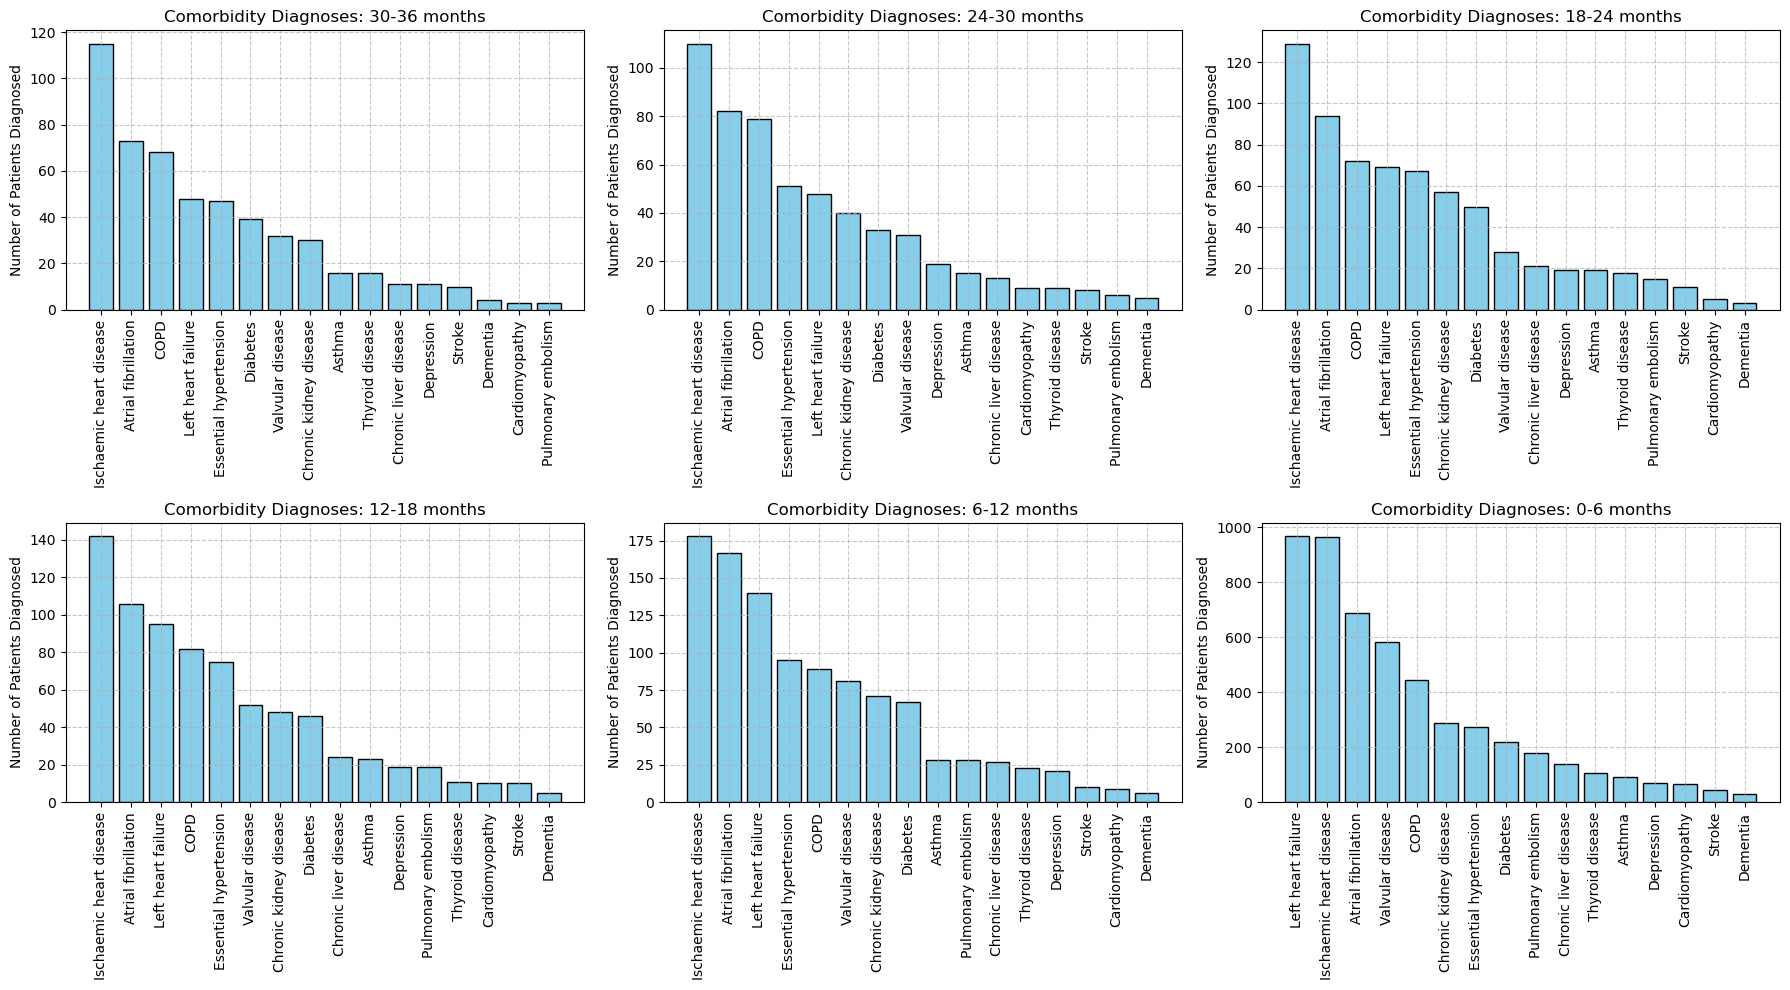

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

time_buckets = ['30-36 months', '24-30 months', '18-24 months', '12-18 months', '6-12 months', '0-6 months']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))  
axes = axes.flatten()  # to easily iterate

for i, bucket in enumerate(time_buckets):
    ax = axes[i]
    sorted_data = pivot_table[bucket].sort_values(ascending=False)
    ax.bar(sorted_data.index, sorted_data.values, color='skyblue', edgecolor='black')
    ax.set_title(f'Comorbidity Diagnoses: {bucket}')
    ax.set_ylabel('Number of Patients Diagnosed')
    ax.set_xticklabels(sorted_data.index, rotation=90)
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


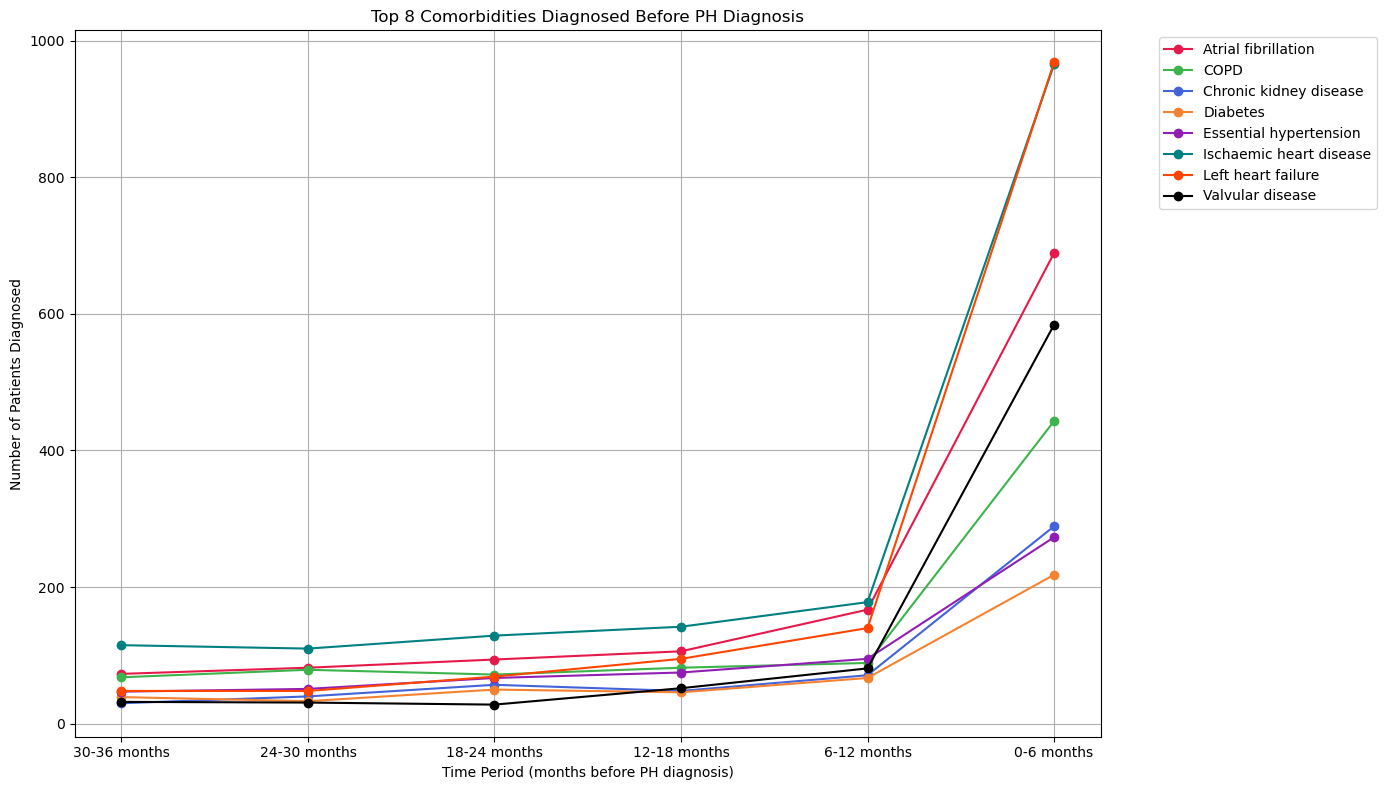

In [ ]:
# Top 8 comorbidities
total_counts = merged['Mapped Disease'].value_counts().nlargest(8).index.tolist()

# Filter pivot table to only top 8 diseases
top8_pivot_table = pivot_table.loc[pivot_table.index.isin(total_counts)]

# Plot
bold_colors = [
    '#e6194b', '#3cb44b', '#4363d8', '#f58231',
    '#911eb4', '#008080', '#ff4500', '#000000' 
]

plt.figure(figsize=(14, 8))
for idx, disease in enumerate(top8_pivot_table.index):
    plt.plot(
        top8_pivot_table.columns,
        top8_pivot_table.loc[disease],
        marker='o',
        label=disease,
        color=bold_colors[idx]
    )

plt.xlabel('Time Period (months before PH diagnosis)')
plt.ylabel('Number of Patients Diagnosed')
plt.title('Top 8 Comorbidities Diagnosed Before PH Diagnosis')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/_m/m9xv09r905g36k6kpxs2mq1r0000gn/T/ipykernel_61764/3761886482.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sorted_data.index, rotation=90)
/var/folders/_m/m9xv09r905g36k6kpxs2mq1r0000gn/T/ipykernel_61764/3761886482.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sorted_data.index, rotation=90)
/var/folders/_m/m9xv09r905g36k6kpxs2mq1r0000gn/T/ipykernel_61764/3761886482.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sorted_data.index, rotation=90)
/var/folders/_m/m9xv09r905g36k6kpxs2mq1r0000gn/T/ipykernel_61764/3761886482.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocato

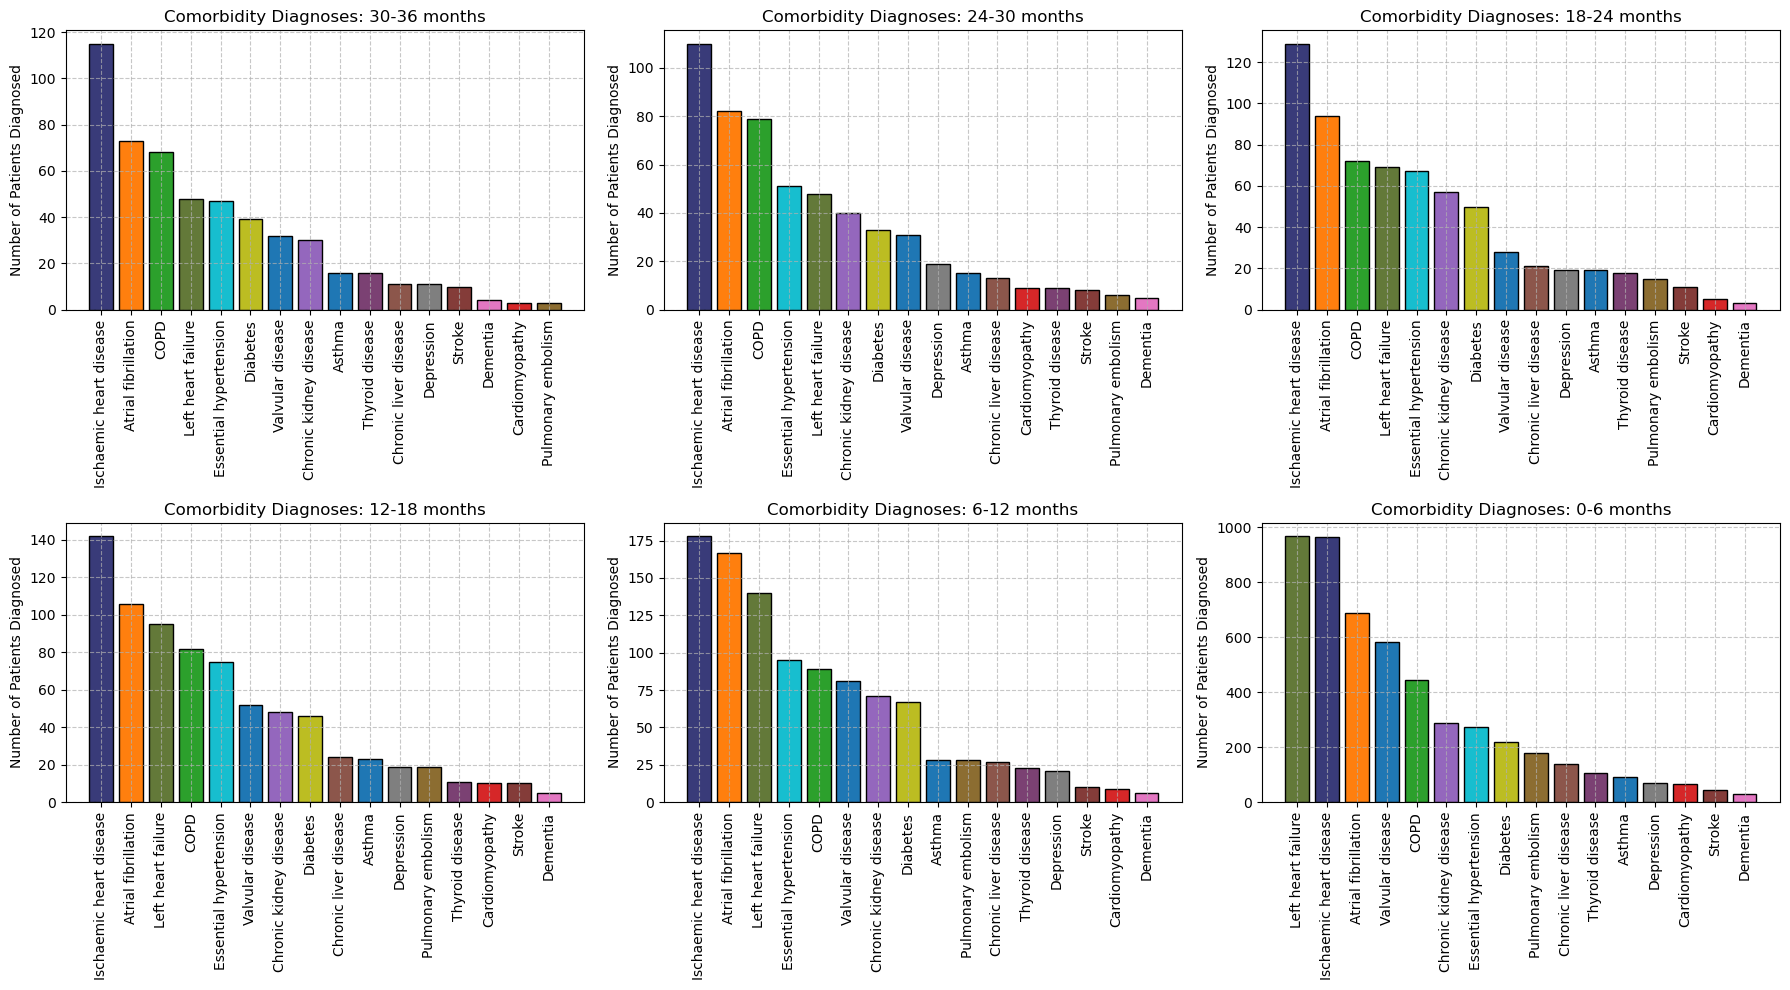

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# color map
color_palette = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#393b79', '#637939', '#8c6d31', '#843c39', '#7b4173'
]

# map diseases to colors
unique_diseases = pivot_table.index.tolist()
disease_color_map = {
    disease: color_palette[i % len(color_palette)]
    for i, disease in enumerate(unique_diseases)
}

# Plot
time_buckets = ['30-36 months', '24-30 months', '18-24 months',
                '12-18 months', '6-12 months', '0-6 months']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, bucket in enumerate(time_buckets):
    ax = axes[i]
    sorted_data = pivot_table[bucket].sort_values(ascending=False)
    
    bar_colors = [disease_color_map[disease] for disease in sorted_data.index]
    
    ax.bar(sorted_data.index, sorted_data.values, color=bar_colors, edgecolor='black')
    ax.set_title(f'Comorbidity Diagnoses: {bucket}')
    ax.set_ylabel('Number of Patients Diagnosed')
    ax.set_xticklabels(sorted_data.index, rotation=90)
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

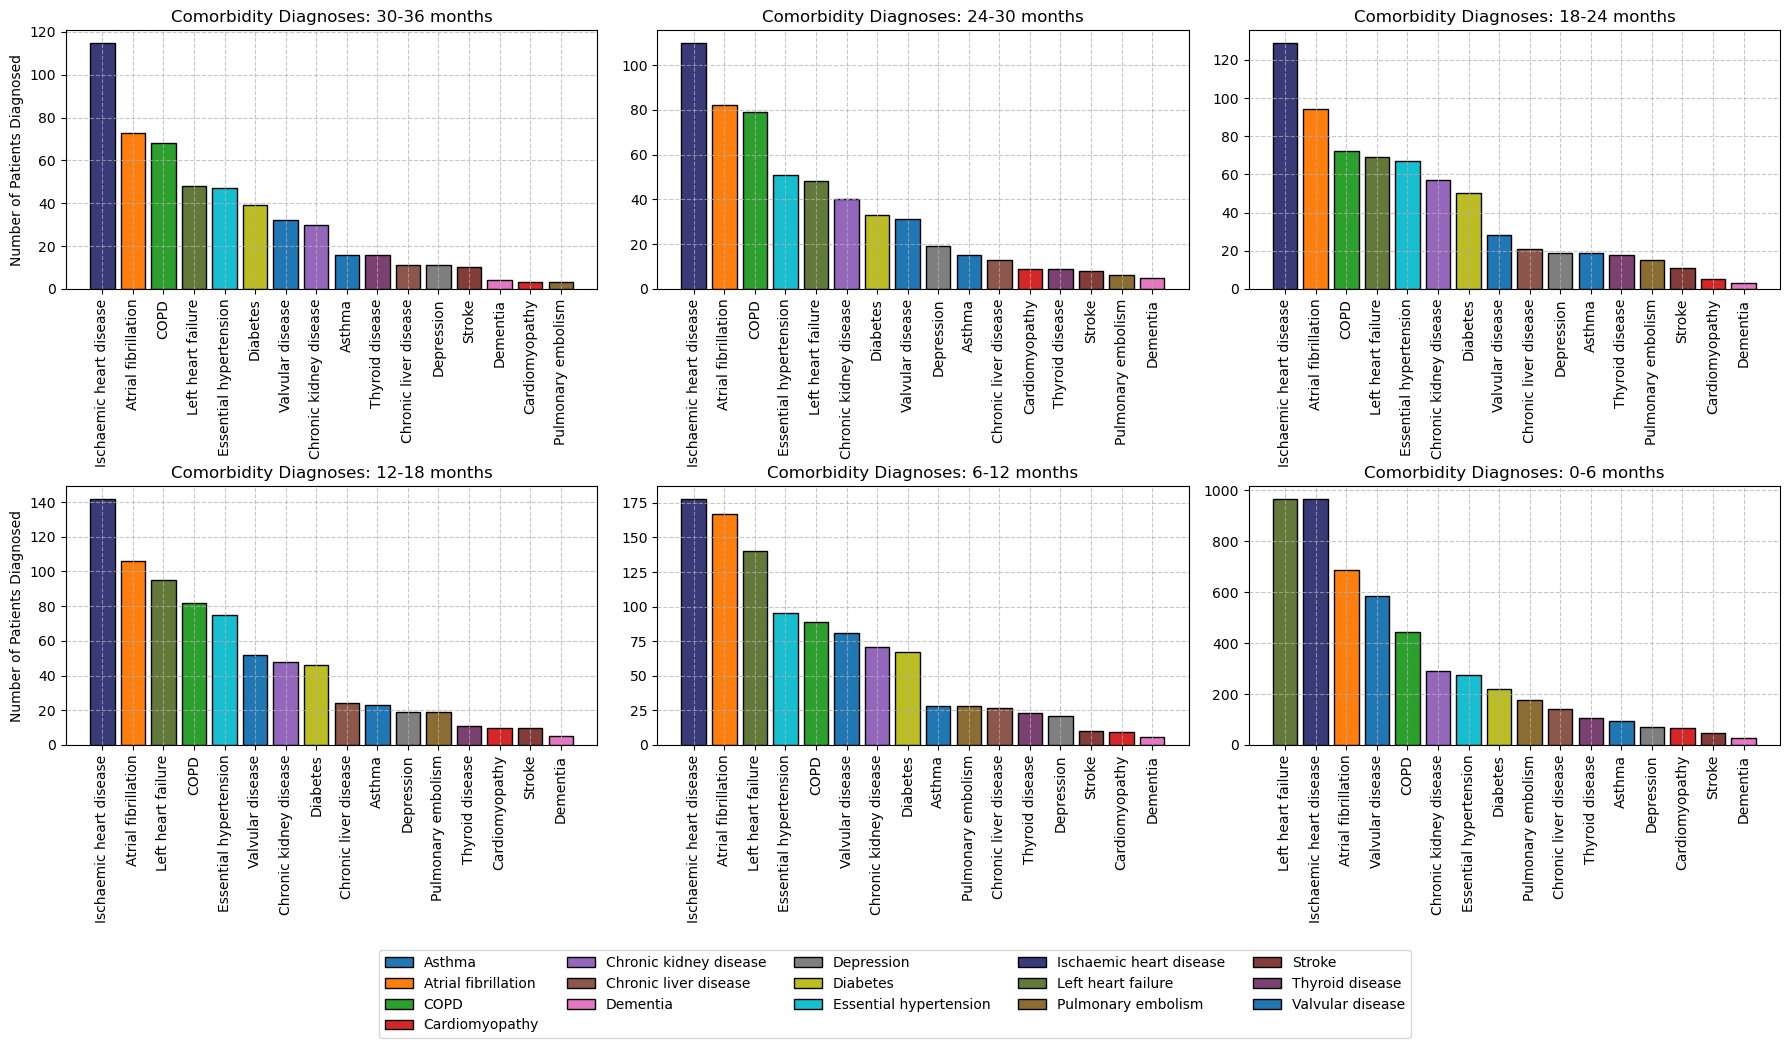

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Color map
color_palette = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#393b79', '#637939', '#8c6d31', '#843c39', '#7b4173'
]

# Map diseases to colors
unique_diseases = pivot_table.index.tolist()
disease_color_map = {
    disease: color_palette[i % len(color_palette)]
    for i, disease in enumerate(unique_diseases)
}

# Legend handles
legend_elements = [
    Patch(facecolor=color, edgecolor='black', label=disease)
    for disease, color in disease_color_map.items()
]

# Time buckets
time_buckets = ['30-36 months', '24-30 months', '18-24 months',
                '12-18 months', '6-12 months', '0-6 months']

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, bucket in enumerate(time_buckets):
    ax = axes[i]
    sorted_data = pivot_table[bucket].sort_values(ascending=False)
    bar_colors = [disease_color_map[disease] for disease in sorted_data.index]
    
    ax.bar(sorted_data.index, sorted_data.values, color=bar_colors, edgecolor='black')
    ax.set_title(f'Comorbidity Diagnoses: {bucket}')
    ax.tick_params(axis='x', rotation=90)

    # Only show y-axis label on the first plot of each row
    if i % 3 != 0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel('Number of Patients Diagnosed')

    ax.grid(True, linestyle='--', alpha=0.7)

# Add shared legend below the subplots
fig.legend(
    handles=legend_elements,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=5,
    frameon=True
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # make room for legend
plt.show()


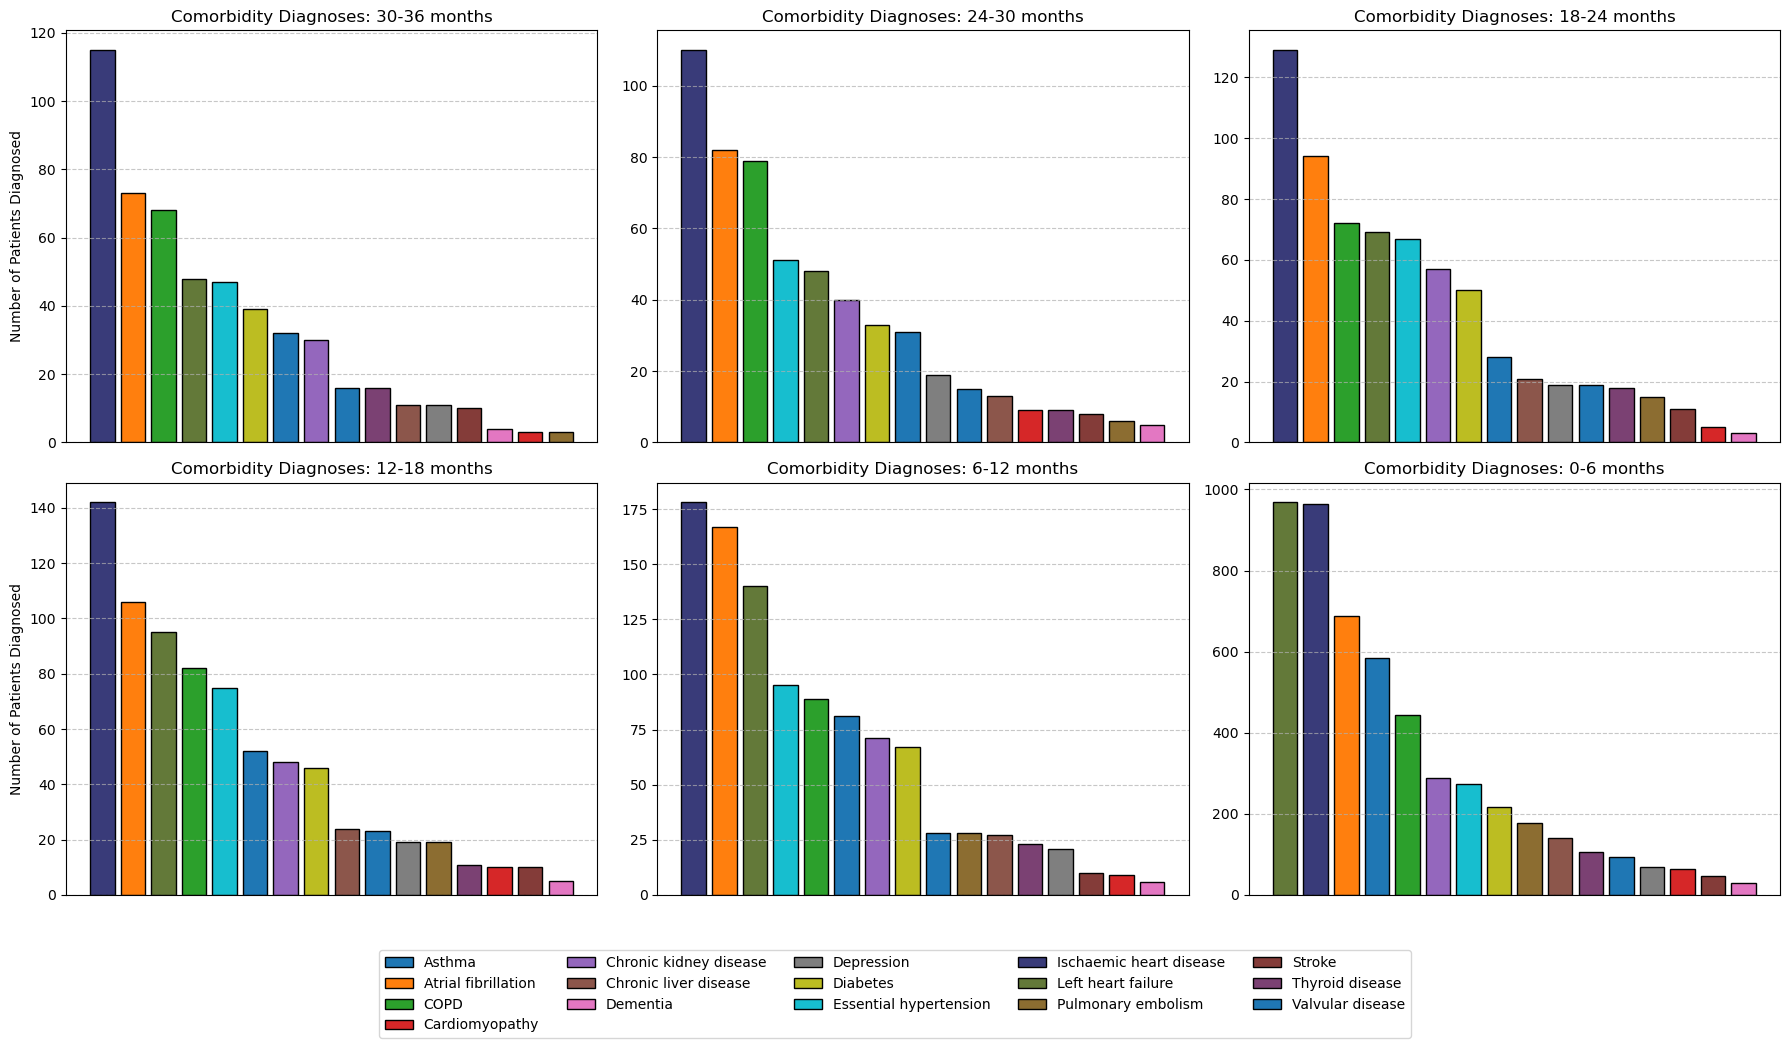

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Color map
color_palette = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#393b79', '#637939', '#8c6d31', '#843c39', '#7b4173'
]

# Map diseases to colors
unique_diseases = pivot_table.index.tolist()
disease_color_map = {
    disease: color_palette[i % len(color_palette)]
    for i, disease in enumerate(unique_diseases)
}

# Legend handles
legend_elements = [
    Patch(facecolor=color, edgecolor='black', label=disease)
    for disease, color in disease_color_map.items()
]

# Time buckets
time_buckets = ['30-36 months', '24-30 months', '18-24 months',
                '12-18 months', '6-12 months', '0-6 months']

# Plot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, bucket in enumerate(time_buckets):
    ax = axes[i]
    sorted_data = pivot_table[bucket].sort_values(ascending=False)
    bar_colors = [disease_color_map[disease] for disease in sorted_data.index]

    ax.bar(sorted_data.index, sorted_data.values, color=bar_colors, edgecolor='black')
    ax.set_title(f'Comorbidity Diagnoses: {bucket}')
    
    # Remove x-axis labels
    ax.set_xticks([])

    # Only show y-axis label on first plot of each row
    if i % 3 != 0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel('Number of Patients Diagnosed')

    ax.grid(True, linestyle='--', alpha=0.7)

# legend below
fig.legend(
    handles=legend_elements,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=5,
    frameon=True
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)  # room for legend
plt.show()